In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm

Let's begin with training an example NN with Jax/Flax

100%|██████████| 1000/1000 [00:00<00:00, 6806.16it/s]


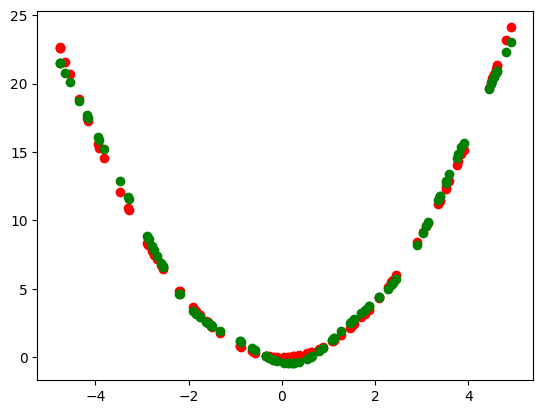

In [2]:
# Define the model
class SimpleMLP(nn.Module):
  def setup(self):
    self.dense1 = nn.Dense(features=10)
    self.dense2 = nn.Dense(features=1)

  def __call__(self, x):
    x = self.dense1(x)
    x = nn.gelu(x)
    x = self.dense2(x)
    return x

# Generate some training data
key = jax.random.PRNGKey(0)
x_train = jax.random.uniform(key, (100, 1), minval=-5., maxval=5.)
y_train = x_train ** 2

# Initialise the model and optimiser
model = SimpleMLP()
params = model.init(jax.random.PRNGKey(1), x_train)
optimiser = optax.adam(learning_rate=0.01)
my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

# Define the loss function
def loss_fn(params, x, y):
  y_pred = model.apply(params, x)
  loss = jnp.mean((y_pred - y) ** 2)
  return loss

# Define the training step
@jax.jit
def train_step(state, x, y):
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params, x, y)
  state = state.apply_gradients(grads=grads)
  return state, loss

# Train the model
for i in tqdm(range(1000)):
  my_state, loss = train_step(my_state, x_train, y_train)


# Evaluate the model
y_pred = model.apply(my_state.params, x_train)
plt.plot(x_train, y_train, 'ro')
plt.plot(x_train, y_pred, 'go')
plt.show()
